In [1]:

%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
# import utils
from adjustText import adjust_text


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/'
pdfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/processed/'
sc.settings.figdir = pfp

In [3]:
hum_dge = glob.glob(os.path.join(pfp, 'deg_hum_imp_samp_OL.csv'))

In [4]:
humanol = [
    'PPP2R2B', #Down
    'PDE4B',
    'PLP1',
    'NKAIN2',
    'MBP',
    'DLC1',
    'NKAIN2',
    'HAPLN2',
    'SLC5A11',
    'NCKAP5',
    'CTNNA3',
    'DPYD',
    'PDE4D',
    'SAMD12',
    'BCAS1',
    'GPM6B',
    'S100B',
    'PCDH9',
    'PKP4',
    'GNG7',
    'KCNIP4', #UP
    'ADGRB3',
    'DCC',
    'ZNF385D',
    'NCAM2',
    'PLCG2',
    'PLXDC2',
    'AMER2',
    'CDH18',
    'ANK3',
    'RALYL',
    'PHLPP1',
    'GRID2',
    'HSPA1A',
    'FCHSD2',
    'ERBB4',
    'LAMA2',
    'FGF14',
    'GRIK2',
    'FRYL',
]

<ipython-input-6-99b6fb9f0c36>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
<ipython-input-6-99b6fb9f0c36>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
<ipython-input-6-99b6fb9f0c36>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

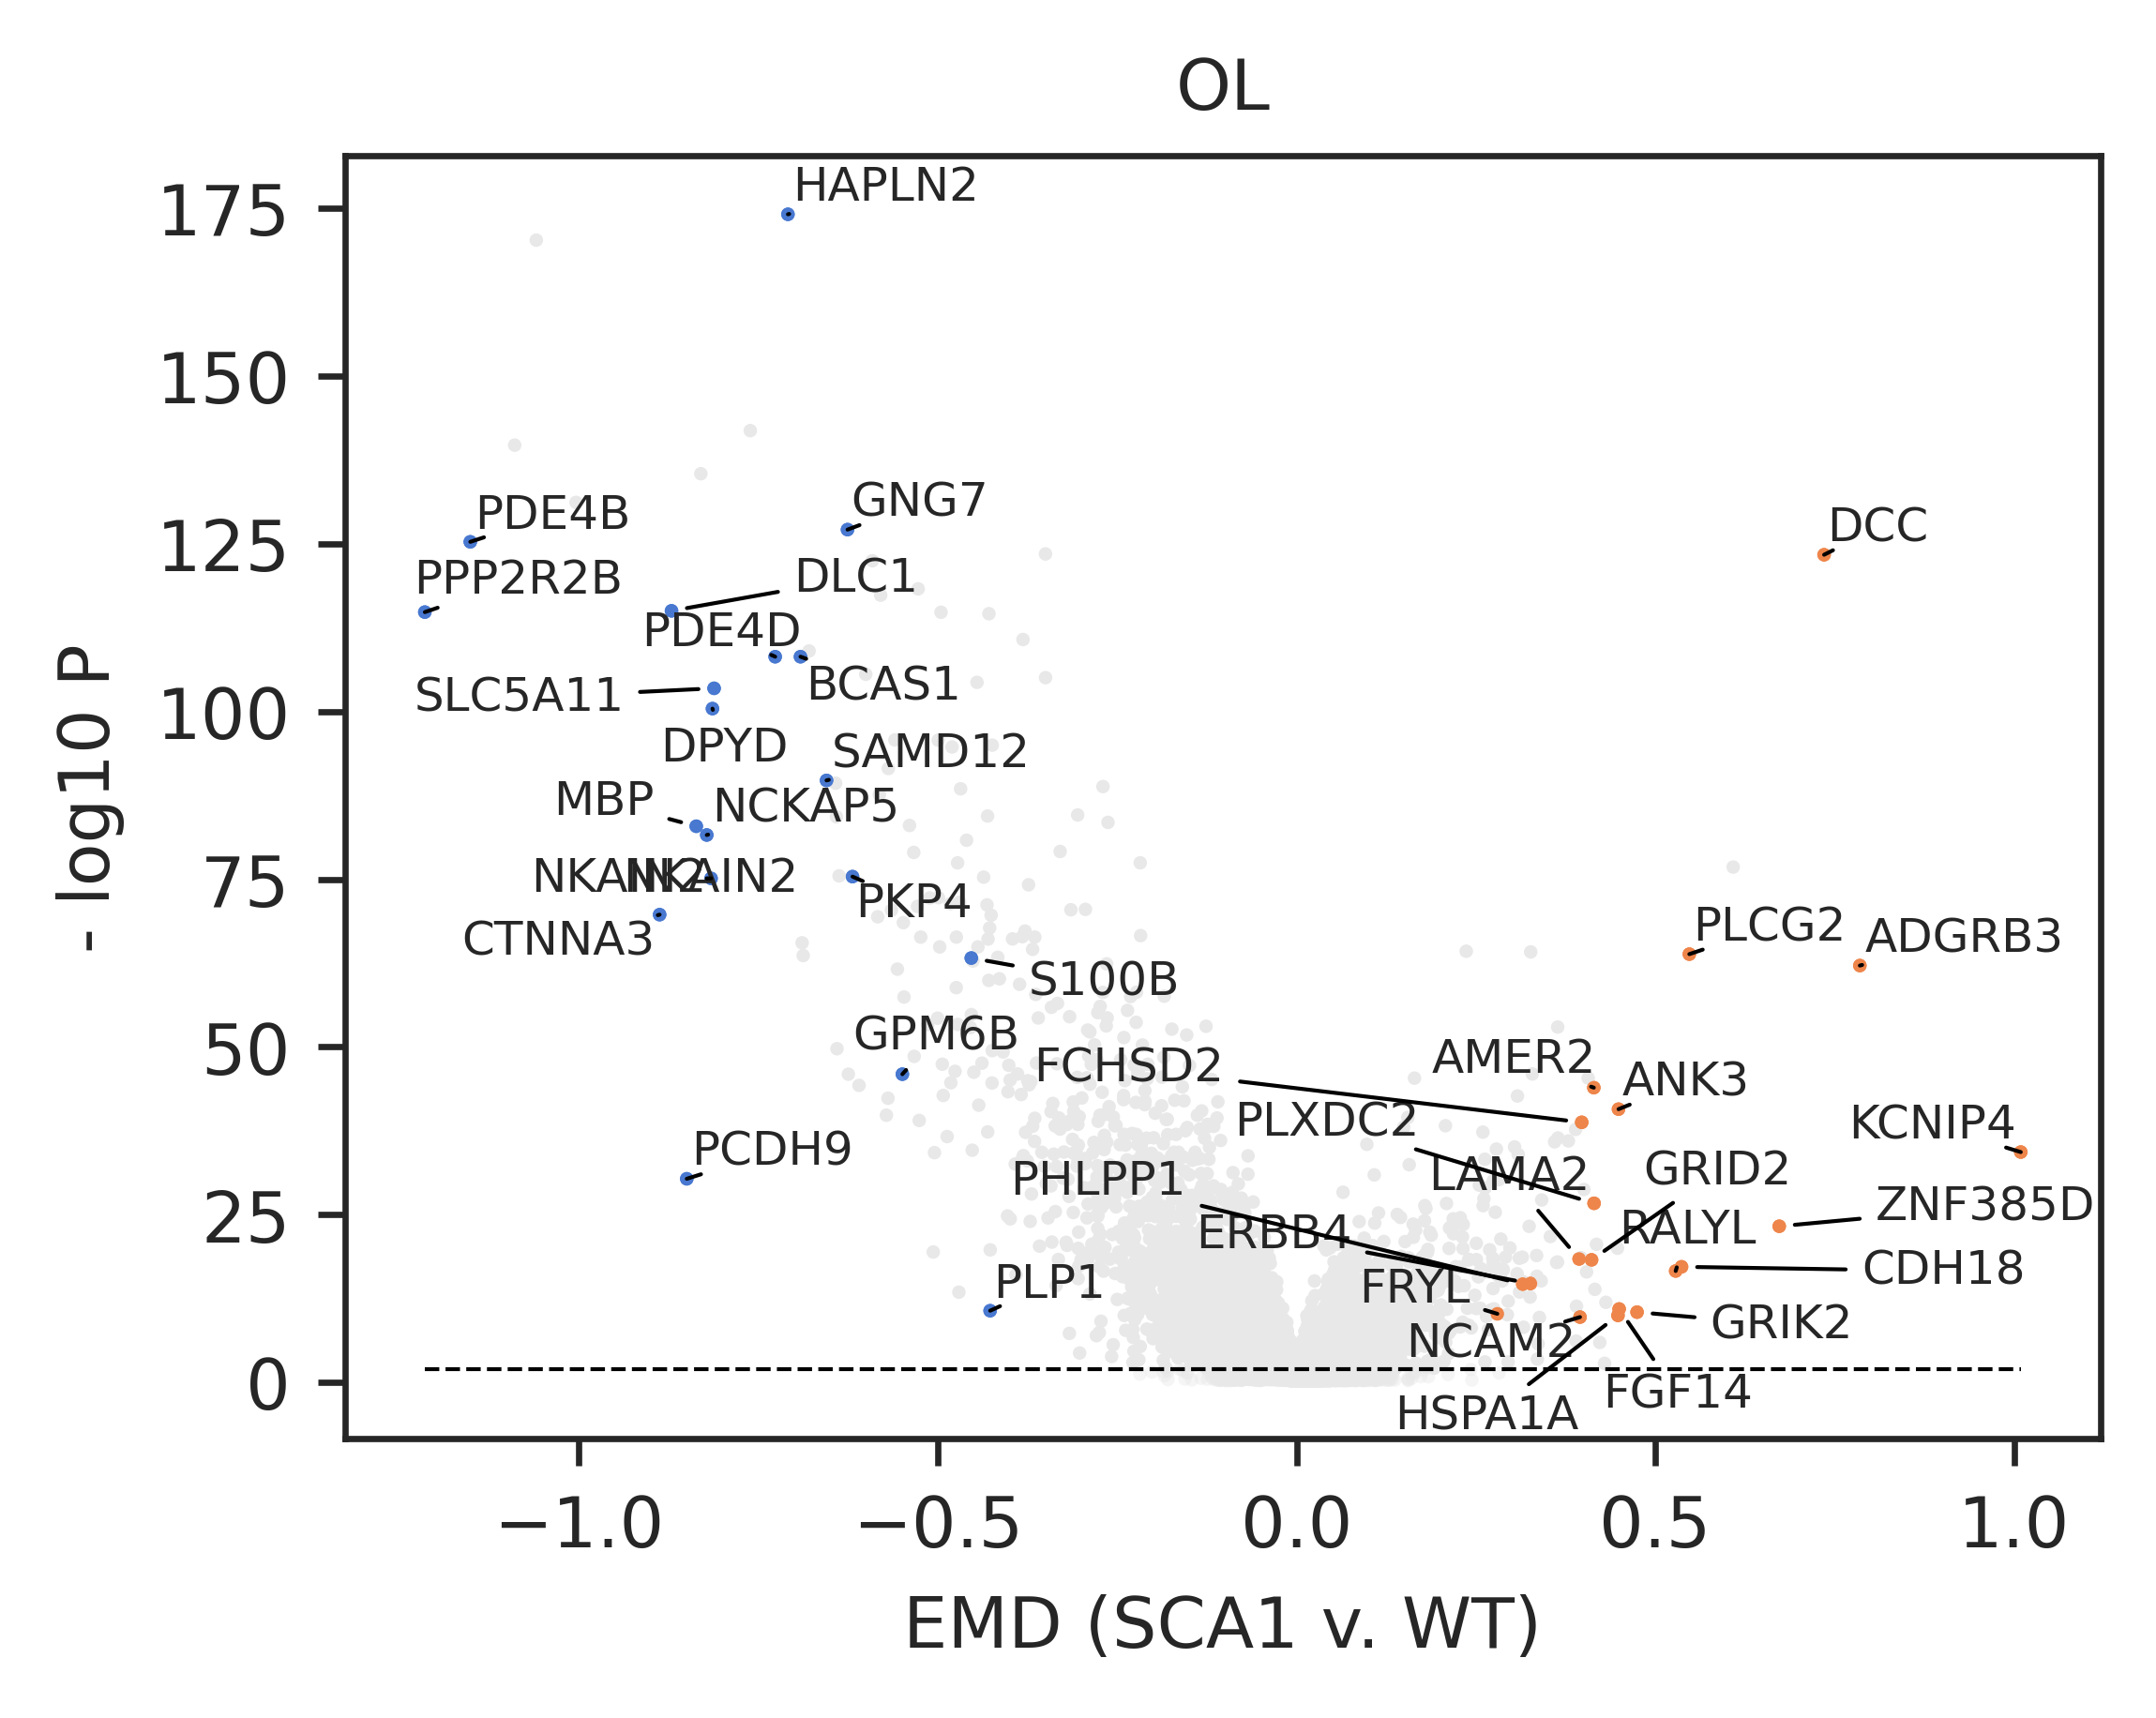

In [6]:
# filter the dge a bit
# change #NAME? to inf or -inf in ['Log2FC']
fname = os.path.join(pfp, '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/deg_hum_imp_samp_OL.csv')
genes_volcano = humanol
ctype = 'OL'

if True:
    # load
    dge = pd.read_csv(fname)


# just work with plot of interest
dt = dge.loc[(dge['Cell type']==ctype),:]

if True:
    # drop mito, ribosomal, and MALAT1 genes
#     genes2exclude = [g for g in dt['Gene'] if 'mt-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    genes2exclude = [g for g in dt['Gene'] if 'MT-' in g] + ['MALAT1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]
    dt['emd'] = dt['emd']*-1


# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'] = np.ceil(dt.loc[~dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'].max())
#dt.loc[dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'] = np.ceil(dt.loc[~dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'].max())
if False:
    # just label top 10 and bottom 10
    dt = dt.sort_values(by='emd') # sort by EMD
    dt = dt.reset_index()
    top10 = dt['Gene'][0:10].to_list()
    bottom10 = dt['Gene'][-10:].to_list()
    genes_volcano = top10+bottom10

## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Down'

## plot
fig,ax=plt.subplots(1,1,figsize=(4,3))
p2=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
p2top=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
ax.plot([dt['emd'].min(),dt['emd'].max()],
        (-1)*np.log10([0.01,0.01]),
        'k--',lw=0.5) # BH cut off
ax.set(xlabel='EMD (SCA1 v. WT)',ylabel='- log10 P', title='{}'.format(ctype))



#     idx_g={}
#     for g in genes_volcano: # match fname with dict key
#         idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

#     texts = [ax.text(dt['emd'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
texts = [ax.text(dt.loc[dt['Gene']==g, 'emd'].values, dt.loc[dt['Gene']==g, 'nlog10pvalcorrected'].values, g, fontsize=6) for g in genes_volcano]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'volcano_{}.pdf'.format(ctype)),dpi=300, bbox_inches='tight')

In [7]:
humanol2 = ['PLP1',
            'MBP',
            'CNP',
            'MOG',
            'CLDN11',
            'CD9',
            'MAG',
            'NFASC',
            'MAP1B',
            'CRYAB',
            'SIRT2',
            'SEPTIN8',
            'PLLP',
            'MOBP',
            'SEPTIN7',
]

<ipython-input-8-51c3ddda255a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
<ipython-input-8-51c3ddda255a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
<ipython-input-8-51c3ddda255a>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

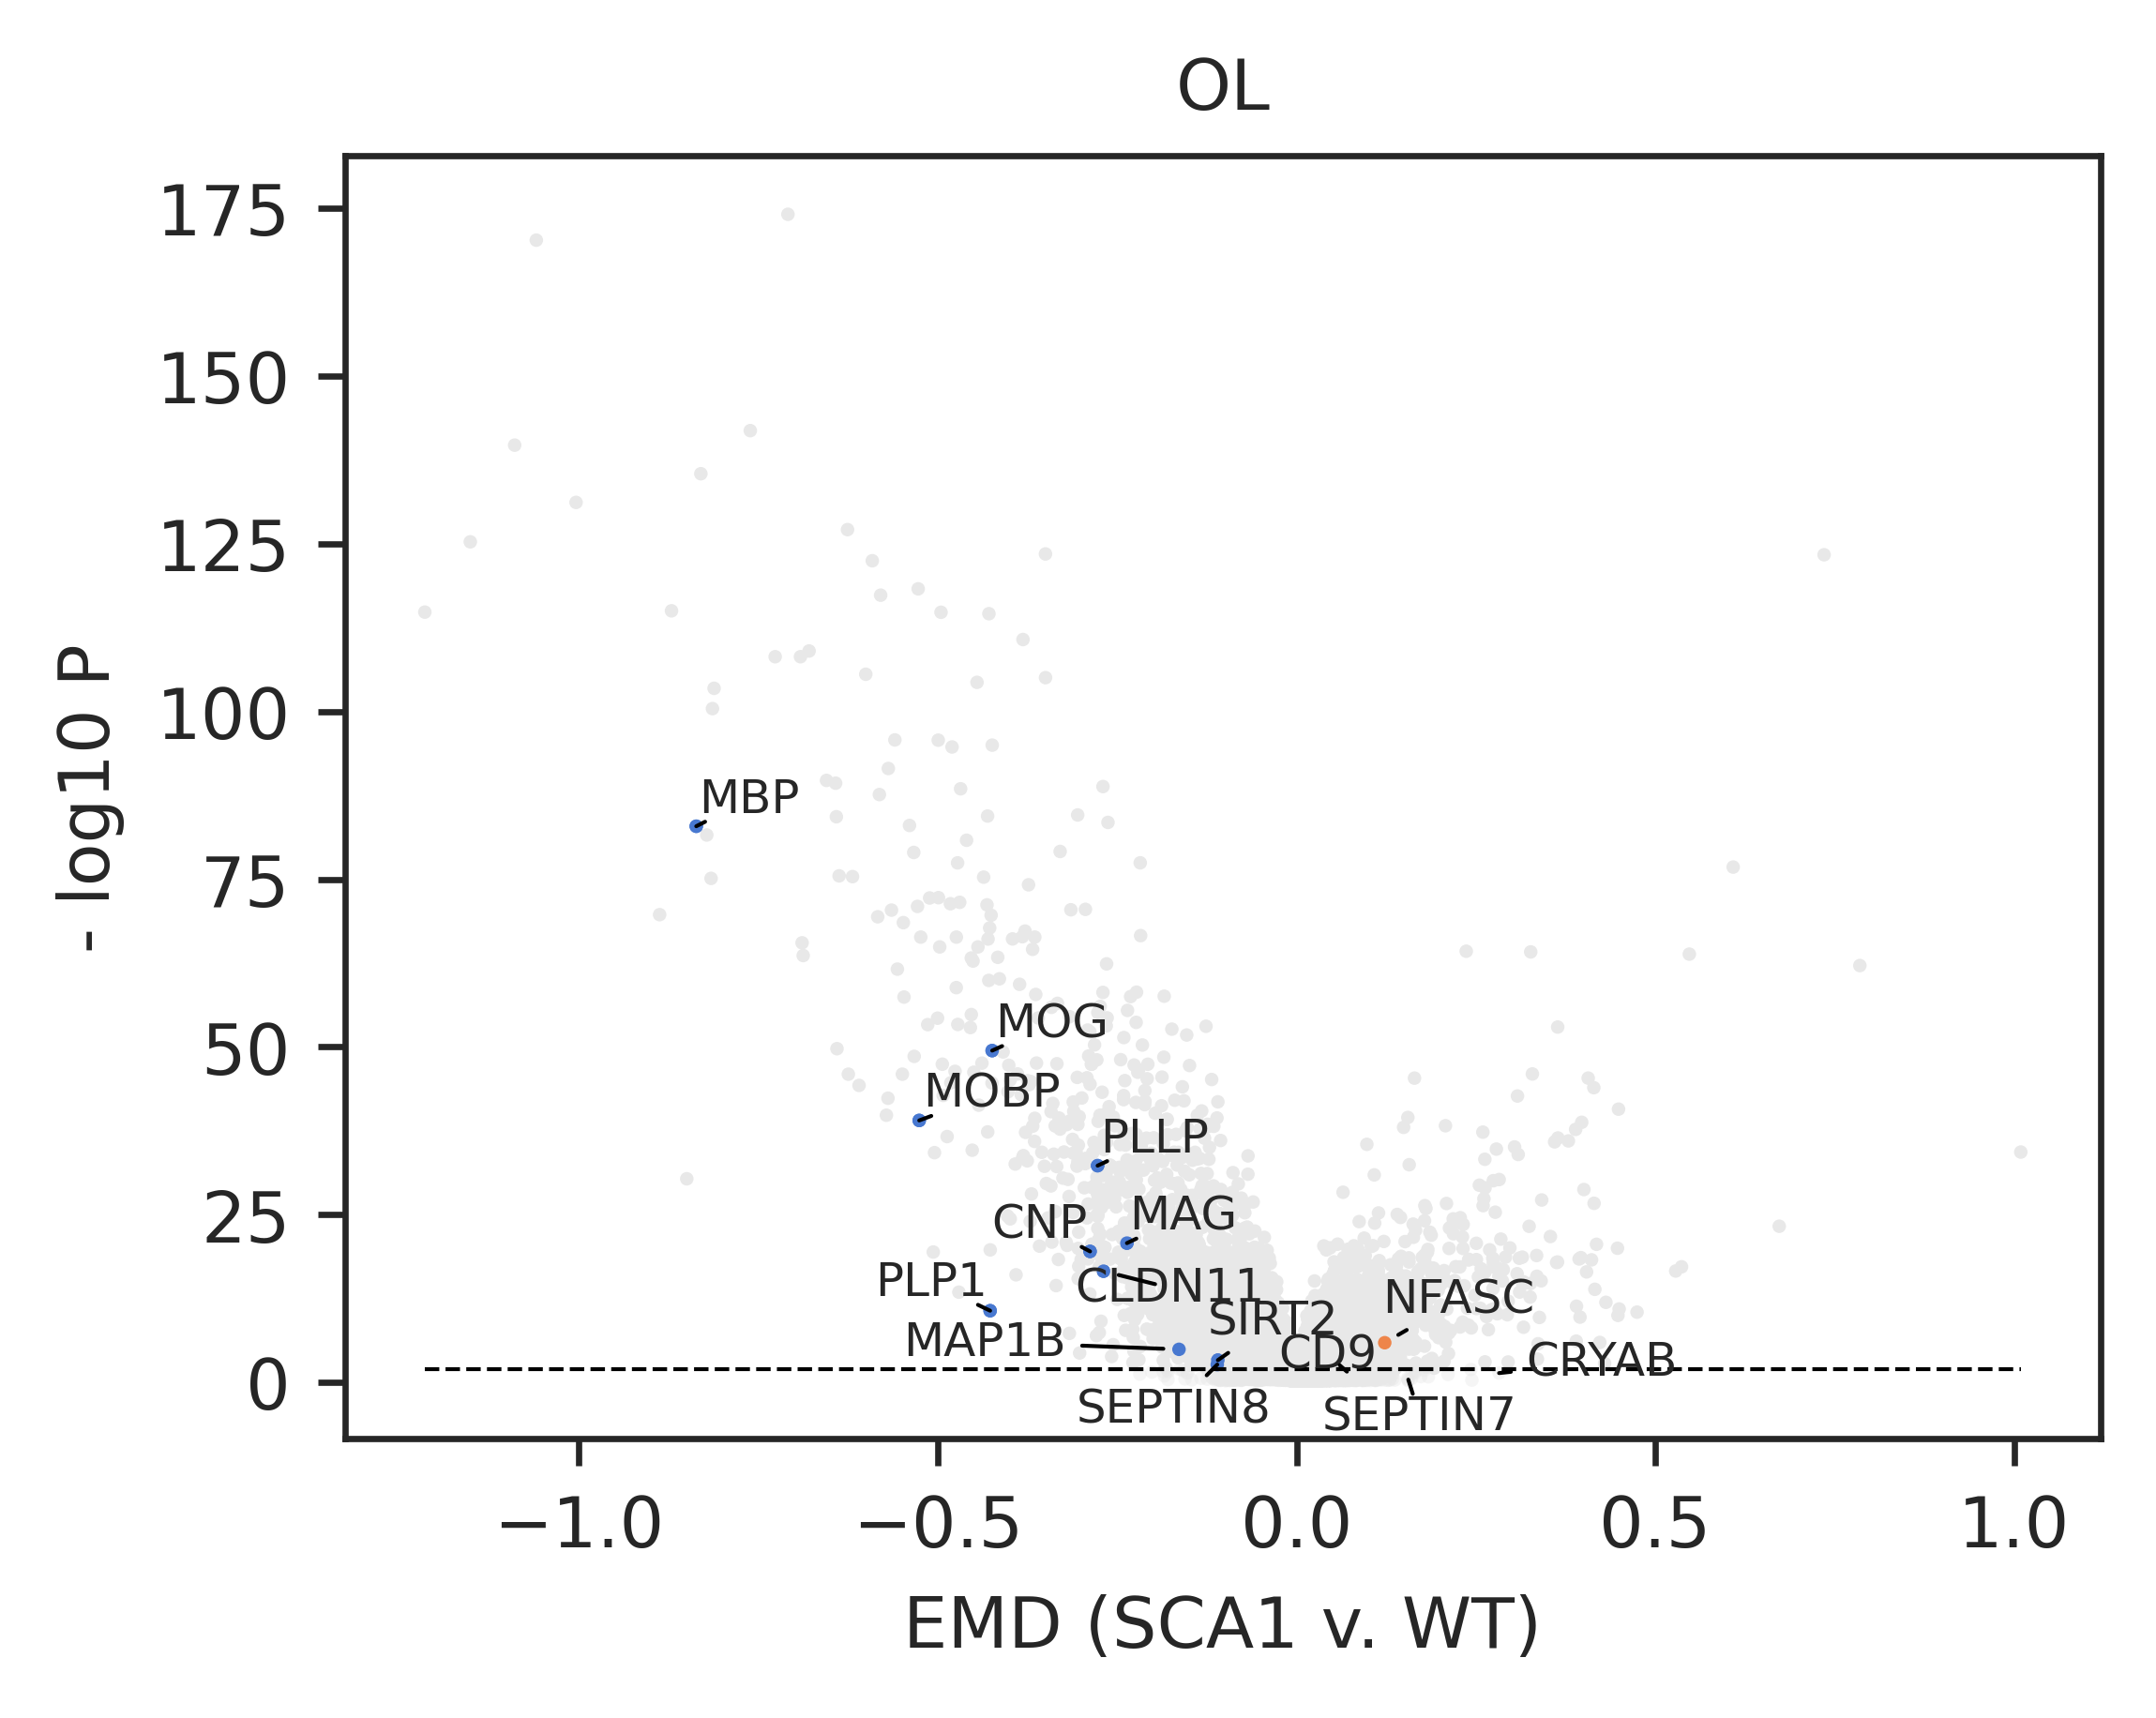

In [8]:
# filter the dge a bit
# change #NAME? to inf or -inf in ['Log2FC']
fname = os.path.join(pfp, '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/deg_hum_imp_samp_OL.csv')
genes_volcano = humanol2
ctype = 'OL'

if True:
    # load
    dge = pd.read_csv(fname)


# just work with plot of interest
dt = dge.loc[(dge['Cell type']==ctype),:]

if True:
    # drop mito, ribosomal, and MALAT1 genes
#     genes2exclude = [g for g in dt['Gene'] if 'mt-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    genes2exclude = [g for g in dt['Gene'] if 'MT-' in g] + ['MALAT1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]
    dt['emd'] = dt['emd']*-1


# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'] = np.ceil(dt.loc[~dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'].max())
#dt.loc[dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'] = np.ceil(dt.loc[~dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'].max())
if False:
    # just label top 10 and bottom 10
    dt = dt.sort_values(by='emd') # sort by EMD
    dt = dt.reset_index()
    top10 = dt['Gene'][0:10].to_list()
    bottom10 = dt['Gene'][-10:].to_list()
    genes_volcano = top10+bottom10

## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Down'

## plot
fig,ax=plt.subplots(1,1,figsize=(4,3))
p2=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
p2top=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
ax.plot([dt['emd'].min(),dt['emd'].max()],
        (-1)*np.log10([0.01,0.01]),
        'k--',lw=0.5) # BH cut off
ax.set(xlabel='EMD (SCA1 v. WT)',ylabel='- log10 P', title='{}'.format(ctype))



#     idx_g={}
#     for g in genes_volcano: # match fname with dict key
#         idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

#     texts = [ax.text(dt['emd'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
texts = [ax.text(dt.loc[dt['Gene']==g, 'emd'].values, dt.loc[dt['Gene']==g, 'nlog10pvalcorrected'].values, g, fontsize=6) for g in genes_volcano]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'volcano_{}_top15_myelin_genes.pdf'.format(ctype)),dpi=300, bbox_inches='tight')

In [9]:
humanol3 = ['PLP1',
            'MBP',
            'CNP',
            'MOG',
            'CLDN11',
            'CD9',
            'MAG',
            'NFASC',
            'MAP1B',
            'CRYAB',
            'SIRT2',
            'SEPTIN8',
            'PLLP',
            'MOBP',
            'SEPTIN7',
            'CD81',
            'RTN4',
            'SLC44A1',
            'CNTN1',
            'EPB41L2',
            'GSN',
            'EPB41L3',
            'NCAM1',
            'PADI2',
            'ANLN',
            'SEPTIN2',
            'SEPTIN4',
            'PMP2',
            'CA2',
            'ENPP6',
            'TPPP',
            'IGSF8',
            'RAC1',
            'CD47',
            'SLC12A2',
            'SEPTIN9',
            'CFL1',
            'HEPACAM',
            'MAPK1',
            'BCAS1',
            'CADM4',
            'CDC42',
            'RHOA',
            'JAM3',
            'NDRG1',
            'LGI3',
            'TPPP3',
            'OPALIN',
            'LSAMP',
            'DYNLL1',
]

<ipython-input-10-b90760e06979>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
<ipython-input-10-b90760e06979>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
<ipython-input-10-b90760e06979>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

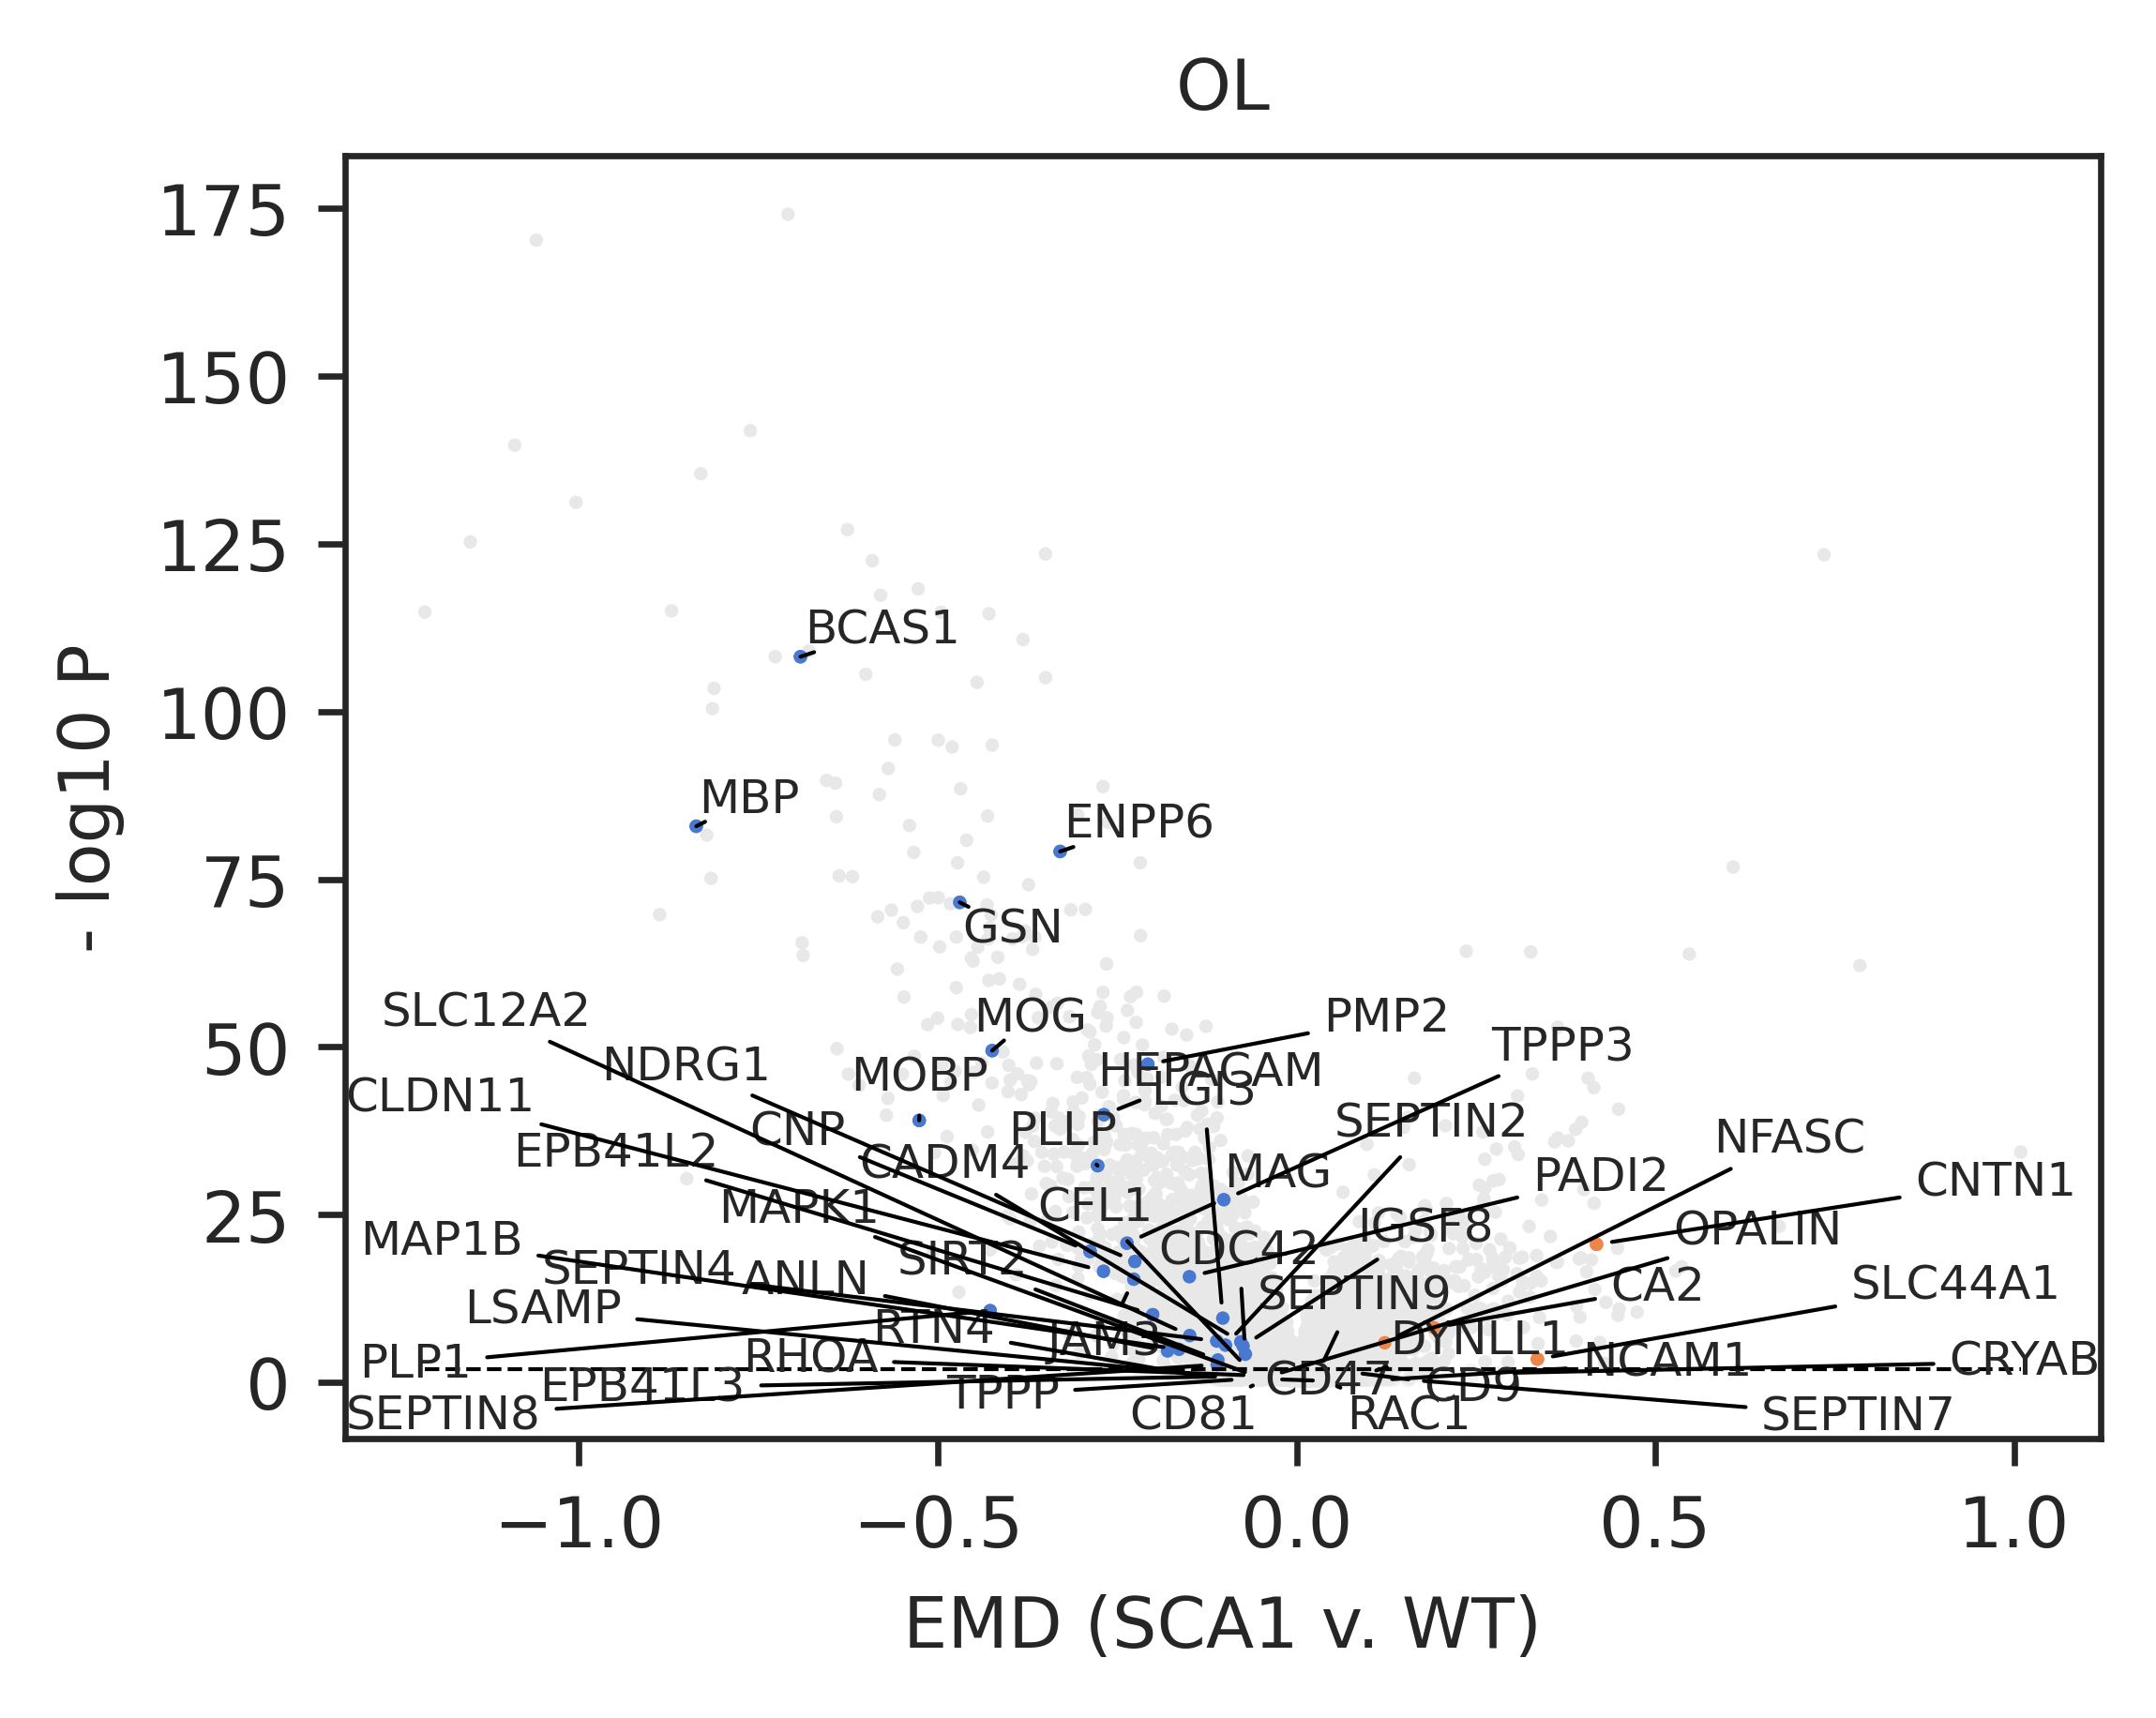

In [10]:
# filter the dge a bit
# change #NAME? to inf or -inf in ['Log2FC']
fname = os.path.join(pfp, '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/deg_hum_imp_samp_OL.csv')
genes_volcano = humanol3
ctype = 'OL'

if True:
    # load
    dge = pd.read_csv(fname)


# just work with plot of interest
dt = dge.loc[(dge['Cell type']==ctype),:]

if True:
    # drop mito, ribosomal, and MALAT1 genes
#     genes2exclude = [g for g in dt['Gene'] if 'mt-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    genes2exclude = [g for g in dt['Gene'] if 'MT-' in g] + ['MALAT1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]
    dt['emd'] = dt['emd']*-1


# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'] = np.ceil(dt.loc[~dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'].max())
#dt.loc[dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'] = np.ceil(dt.loc[~dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'].max())
if False:
    # just label top 10 and bottom 10
    dt = dt.sort_values(by='emd') # sort by EMD
    dt = dt.reset_index()
    top10 = dt['Gene'][0:10].to_list()
    bottom10 = dt['Gene'][-10:].to_list()
    genes_volcano = top10+bottom10

## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Down'

## plot
fig,ax=plt.subplots(1,1,figsize=(4,3))
p2=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
p2top=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
ax.plot([dt['emd'].min(),dt['emd'].max()],
        (-1)*np.log10([0.01,0.01]),
        'k--',lw=0.5) # BH cut off
ax.set(xlabel='EMD (SCA1 v. WT)',ylabel='- log10 P', title='{}'.format(ctype))



#     idx_g={}
#     for g in genes_volcano: # match fname with dict key
#         idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

#     texts = [ax.text(dt['emd'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
texts = [ax.text(dt.loc[dt['Gene']==g, 'emd'].values, dt.loc[dt['Gene']==g, 'nlog10pvalcorrected'].values, g, fontsize=6) for g in genes_volcano]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'volcano_{}_top50_myelin_genes.pdf'.format(ctype)),dpi=300, bbox_inches='tight')

In [11]:
humanol4 = ['PLP1', #TOP29 myelin genes
            'MBP',
            'CNP',
            'MOG',
            'CLDN11',
            'MAG',
            'MAP1B',
            'SEPTIN8',
            'PLLP',
            'MOBP',
            'GSN',
            'PADI2',
            'ANLN',
            'SEPTIN2',
            'PMP2',
            'CA2',
            'ENPP6',
            'SLC12A2',
            'HEPACAM',
            'BCAS1',
            'JAM3',
            'NDRG1',
            'LSAMP',
            'NFASC',
            'CRYAB',
            'SEPTIN7',
            'SLC44A1',
            'CNTN1',
            'NCAM1'
]

<ipython-input-12-42fe77c80ec8>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
<ipython-input-12-42fe77c80ec8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
<ipython-input-12-42fe77c80ec8>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

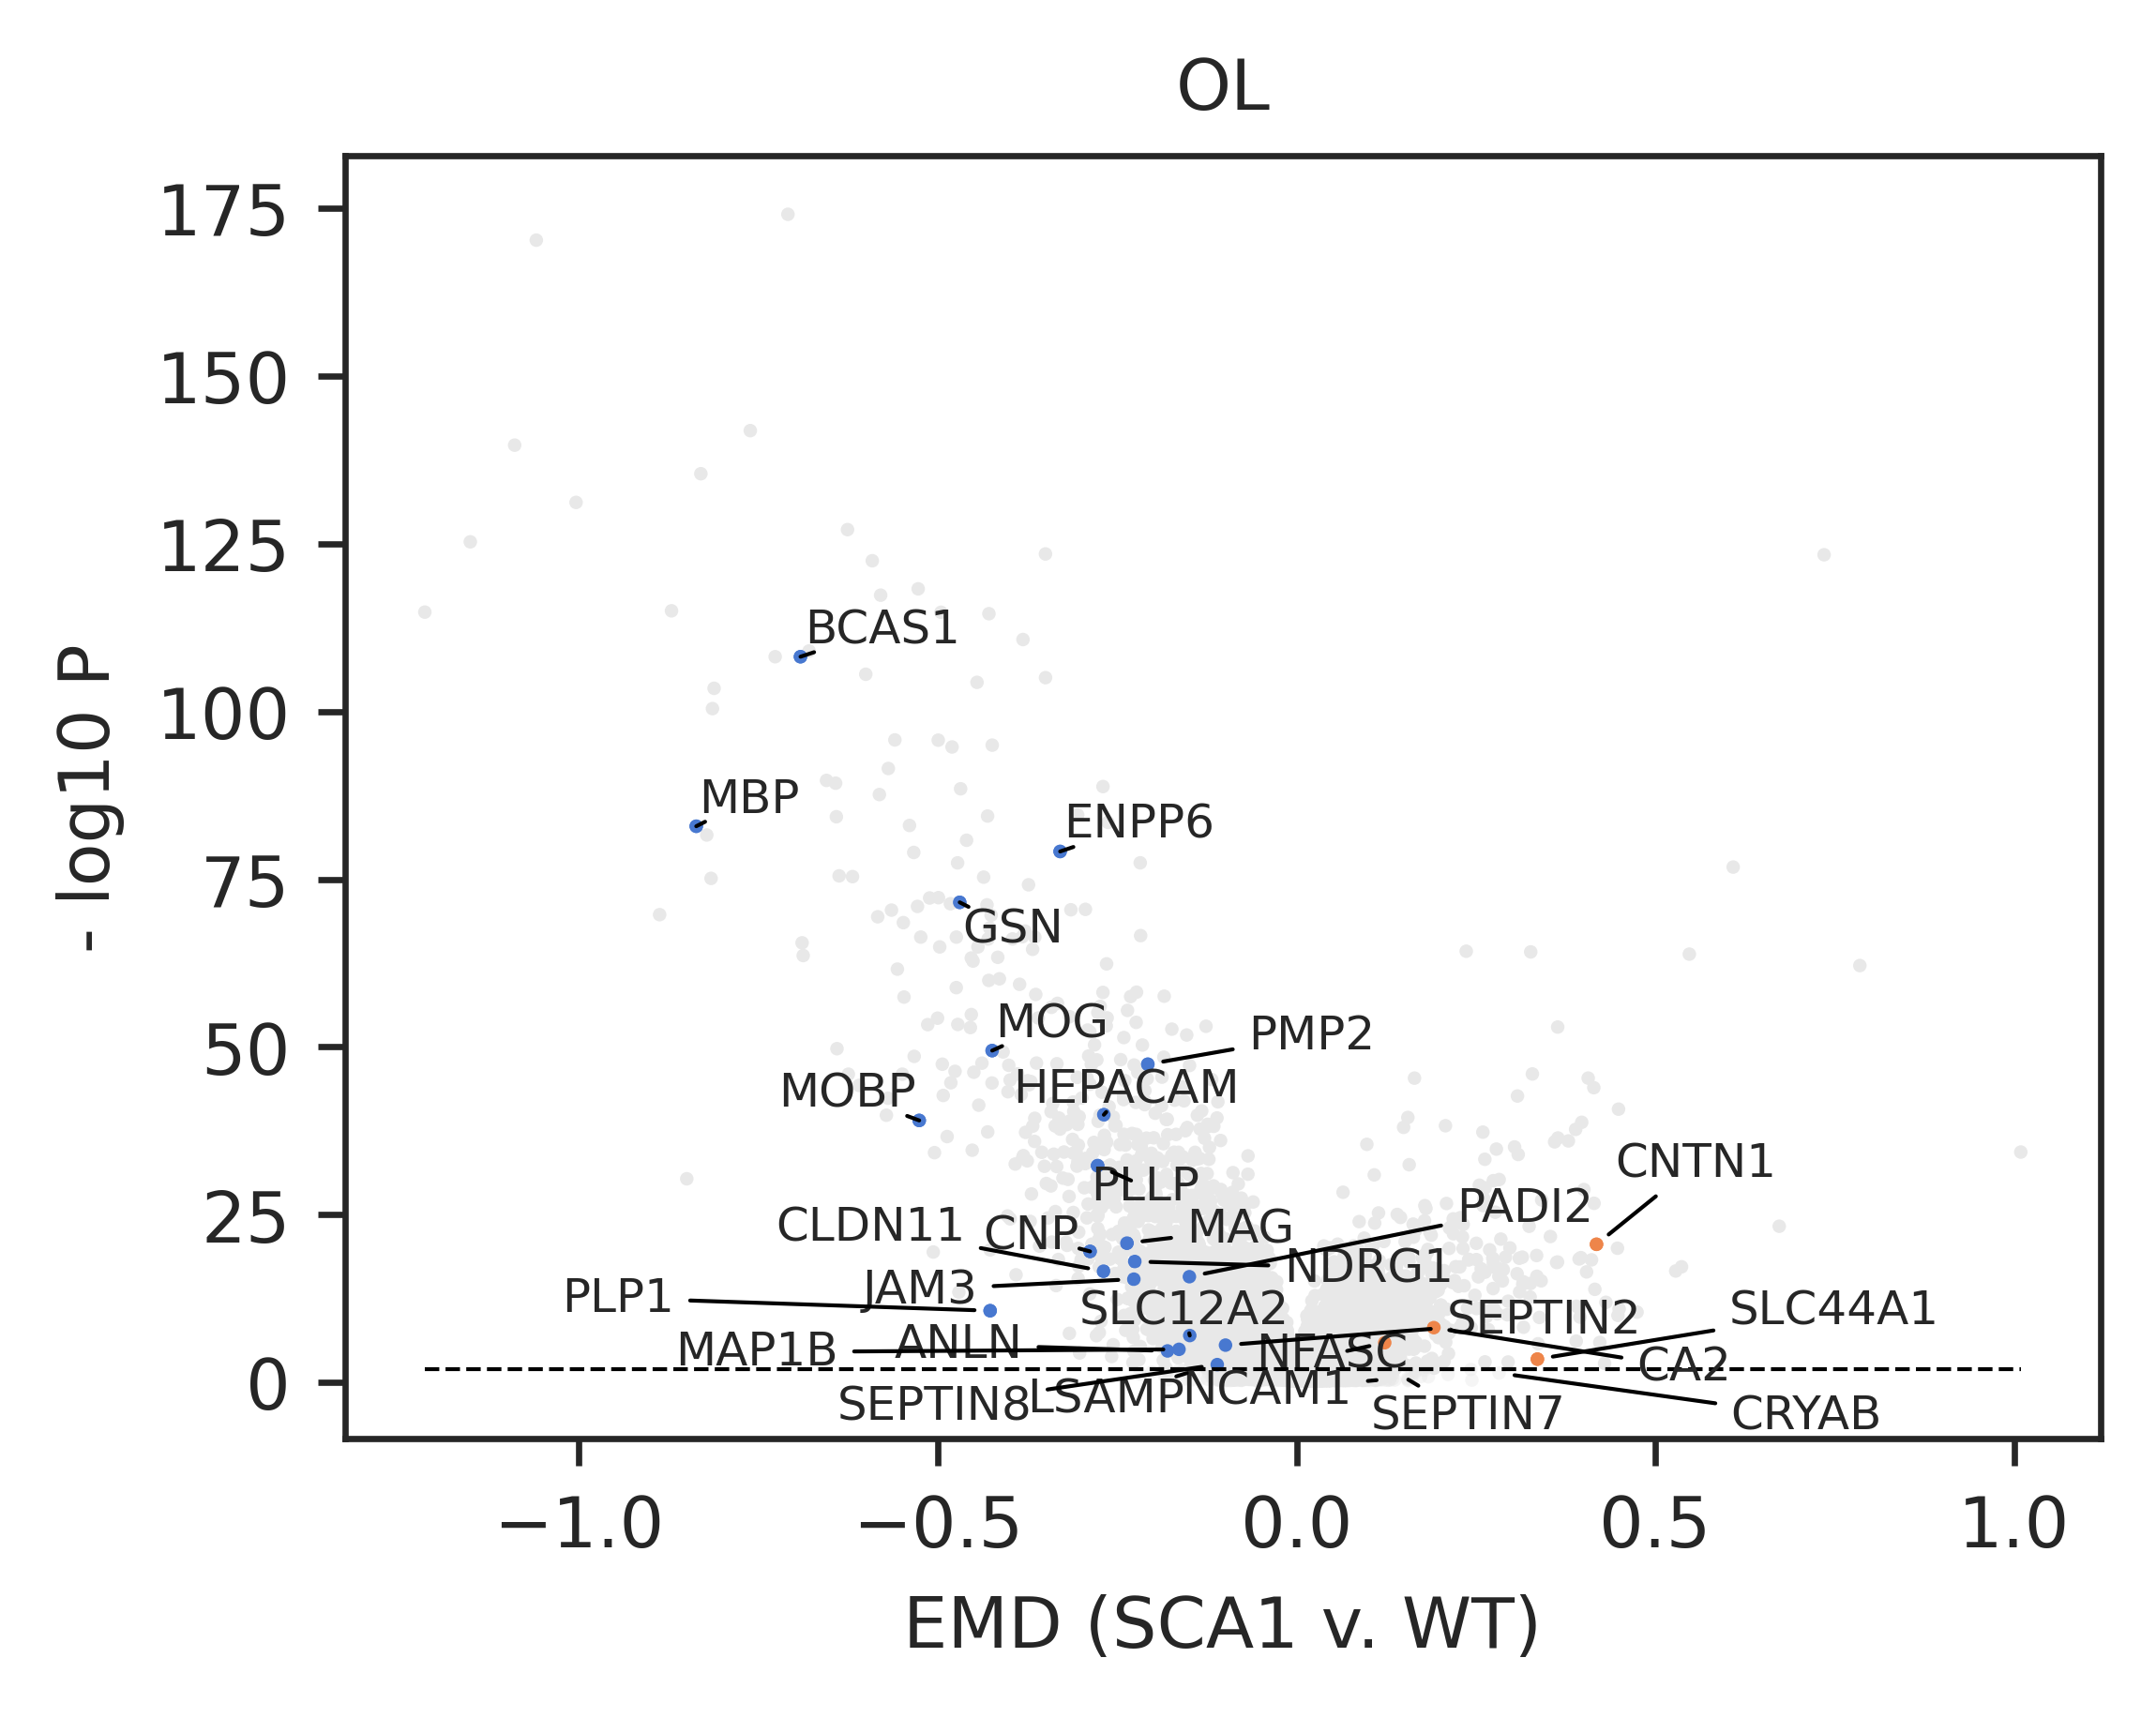

In [12]:
# filter the dge a bit
# change #NAME? to inf or -inf in ['Log2FC']
fname = os.path.join(pfp, '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/deg_hum_imp_samp_OL.csv')
genes_volcano = humanol4
ctype = 'OL'

if True:
    # load
    dge = pd.read_csv(fname)


# just work with plot of interest
dt = dge.loc[(dge['Cell type']==ctype),:]

if True:
    # drop mito, ribosomal, and MALAT1 genes
#     genes2exclude = [g for g in dt['Gene'] if 'mt-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    genes2exclude = [g for g in dt['Gene'] if 'MT-' in g] + ['MALAT1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]
    dt['emd'] = dt['emd']*-1


# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'] = np.ceil(dt.loc[~dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'].max())
#dt.loc[dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'] = np.ceil(dt.loc[~dt['log2FC'].isin([-np.inf, np.inf]), 'log2FC'].max())
if False:
    # just label top 10 and bottom 10
    dt = dt.sort_values(by='emd') # sort by EMD
    dt = dt.reset_index()
    top10 = dt['Gene'][0:10].to_list()
    bottom10 = dt['Gene'][-10:].to_list()
    genes_volcano = top10+bottom10

## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano else False for i in dt['Gene']]))]='Down'

## plot
fig,ax=plt.subplots(1,1,figsize=(4,3))
p2=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
p2top=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
ax.plot([dt['emd'].min(),dt['emd'].max()],
        (-1)*np.log10([0.01,0.01]),
        'k--',lw=0.5) # BH cut off
ax.set(xlabel='EMD (SCA1 v. WT)',ylabel='- log10 P', title='{}'.format(ctype))



#     idx_g={}
#     for g in genes_volcano: # match fname with dict key
#         idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

#     texts = [ax.text(dt['emd'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
texts = [ax.text(dt.loc[dt['Gene']==g, 'emd'].values, dt.loc[dt['Gene']==g, 'nlog10pvalcorrected'].values, g, fontsize=6) for g in genes_volcano]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'volcano_{}_top29_myelin_genes.pdf'.format(ctype)),dpi=300, bbox_inches='tight')